<a href="https://colab.research.google.com/github/myrronaguila/analyze_sqc/blob/main/qutip%20Bloch%20Sphere%20Animation/2Q_Gates_ISWAP_CZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bloch Sphere Animation - 2Q Gates (ISWAP and CZ)
By Myrron Albert Callera Aguila, PhD (First updated 20231018)

## Disclaimer:
Our codes are using only 1Q gates for visualization of said operation. This code base does not yet deal with 2Q circuit gates which requires more-precise evolution based on Unitary Matrix. However, this can be done in its advanced form once the matrix crunching is done properly.

##Imported Libraries

In [ ]:
#Python library installed #34 seconds
!pip install qutip==4.7.3     # for quantum operations => 4.7.3
!pip install qutip-qip==0.3.0 # extension of quantum operations => 0.3.0

!pip install ghostscript==0.7 # for showing transpiler => 0.7
!pip install folium==0.2.1 #error; folium-0.14.0 = org
!pip install pdflatex==0.1.3 #=> 0.1.3

#for mp4 animation
!apt install ffmpeg    # for qubit animation => 7:4.4.2-0ubuntu0.22.04.1
!apt install imagemagick # for image animation => -6.q16
!apt install pdf2svg #convert pdf2svg for circuit list =>
!sudo apt-get install texlive-latex-recommended #textlive latex => none
!sudo mv /etc/ImageMagick-6/policy.xml /etc/ImageMagick-6/policy.xml.off #needed for qip setup to work
!sudo apt install texlive-latex-extra #data analysis => none
!sudo apt install dvipng #convert qutip image to png without latex =>1.15-1.1

#for imageio method then change from gif to .mp4

!pip install Latex==0.7.0 #install latex for listing plots => 0.7.0
!pip install latextools==0.5.0 #install latextools => 0.5.0
#runtime: 2m 33s

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79793 sha256=2ed7451745853a520d9a4b8ddf1199cec7526503ba88231db85ae7261be04a36
  Stored in directory: /root/.cache/pip/wheels/00/0c/07/d7792a5444d5bb074361ac27da53cee9d5cce59a07fe9da5dd
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.6 requires folium>=0.9.1, but you have folium 0.2.1 which is incompatible.
geemap 0.28

In [ ]:
#imported libraries
#computational commands for imported plots
import numpy as np
import scipy
import qutip

#showing installed components
import inspect #useful for printing python modules uploaded
import sys #for printing imported python modules and versions
#runtime = 2m 31s

# perform animation of gate rotation
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
#imported classes from libraries
from functools import partial #useful

#Activate 3D projection
from mpl_toolkits.mplot3d import Axes3D #activate 3D projection on Bloch Sphere

# basis of setting states in Qutip, refer to https://qutip.org/docs/latest/guide/guide-basics.html
# single-qubit gate operation, refer to https://qutip.org/docs/latest/guide/qip/qip-basics.html
from qutip import basis, Qobj, sigmax, sigmay, sigmaz, tensor, expect

from IPython.display import Image # https://github.com/qutip/qutip-qip/issues/64

#from qutip.qip.circuit import QubitCircuit, Gate
from qutip_qip.circuit import QubitCircuit
#add rotation operators for phi and theta - useful for making trajectories
#https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.operations.html#qutip_qip.operations.rotation
from qutip_qip.operations import RX, RY, RZ, Gate #for 1Q gate rotations
from qutip.qip import hadamard_transform #Hadamard evolution

## Important Library

Extract Qubit State

In [ ]:
# no change from 20230928
def extract_state_info_qt(init_state):
  """
  20230926 Data analysis
  Extract appropriate qutip parameters using qt.expect
  # no good analysis if theta and phi have flawed database
  Get coordinates from state. To simplify, we get the theta and phi after
  state readout.
  Input
    init_state: Qobj
      state preparation
    norm: string
      norm='Y' => normalized to unit vector
      norm='N' => get raw state
  Output:
    dict_info: dictionary
      dict_info[0]: list of floats in coordinates
        [u, v, w]
      dict_info[1]: list of floats in radians
        [theta, phi]
      dict_info[2]: list of floats in fractions
        [alpha**2, beta**2]
  """
  #assess whether normalization is important
  alpha, beta = init_state.full().flatten()
  if (np.abs((alpha*np.conj(alpha))) + np.abs((beta*np.conj(beta)))) > 1:
    init_state = init_state.unit()
  else:
    init_state = init_state

  u, v, w = expect([sigmax(), sigmay(), sigmaz()], init_state) #assuming pure-state

  #obtain state angle phi and theta, solved
  theta = np.arccos(w) #rotation between |0> (theta/2=0) to |1> (theta/2=180)
  phi = np.angle(u + 1j*v) #rotation from +x to +y to -x to -y to +x
  if phi < 0:
    #phi correction
    phi += 2*np.pi

  #define coefficient of the state vectors according to psi
  alpha = np.cos(theta/2)
  beta = np.sin(theta/2)*np.exp(1j*phi)

  #data analysis of probabilities
  alpha_sqr = np.abs(alpha*np.conj(alpha))
  beta_sqr = np.abs(beta*np.conj(beta))

  dict_info = {'prob': np.asarray([alpha_sqr, beta_sqr]),
               'coord': np.asarray([u, v, w]),
               'theta_phi': np.asarray([theta, phi]),
               'alpha_beta': np.asarray([alpha, beta])}
  return dict_info

Rotation Gate Animation

In [ ]:
#finalized rot r-angle in degrees
def rot_R(init_list, angle, pts=3):
  """
  Basic rotation gates.

  input:
    init_list: list of objects
      init_list[0] = initial state in Qobj
      init_list[1] = target qubit [default=0] in integer
      init_list[2] = string N -> ['X', 'Y', 'Z', 'H'] rotation on the n-axis
    angle: float
      refers to rotation around a certain axis by degrees [for clarity]. Note
      that the value here is not the same as the theta and phi angles in the
      bloch statevector
    pts: float
      Number of Rotations in the Z-axis, min number of points is 3 just to
      make an arc between two lines for drawing expected trajectories

  output:
    list of unitary matrix, the angle is independent of the qubit state
  """
  # unpack variables
  init_state = init_list[0] #initial state of evolution
  target = init_list[1] #qubit target, initial is 0 for single qubit
  str_rot = init_list[2] #rotation around N-axis

  #check state angle coordinates for Hadamard Gate Transform.
  dict_state = extract_state_info_qt(init_state=init_state)
  theta = dict_state['theta_phi'][0]
  phi = dict_state['theta_phi'][1]
  #print('theta = {:.3f} deg; phi = {:.3f} deg'.format(np.degrees(theta), np.degrees(phi)))
  #RX, RY, and RZ are multidimentional. However, we confine to single-qubit only
  # Set rotations around needed axes and create a list of rotation matrices using qip-operations contrl
  rot_arr = np.linspace(0, angle, pts) # 0 is initial state, angle for variable angles in degrees
  if str_rot == 'X':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RX(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'Y':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RY(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'Z':
    rot_arr = np.linspace(0, 180, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'H':
    #https://physics.stackexchange.com/questions/313959/visual-interpretation-on-the-bloch-sphere-when-hadamard-gate-is-applied-twice
    #the gate - based on hamiltonian transformation
    hadamard = hadamard_transform()
    # the hamilton operator describing the evolution during the hadamard gate
    hamilton = Qobj(scipy.linalg.logm(hadamard.data.todense()), dims=hadamard.dims) / np.pi * 1.j
    # describing the gate as time evolution
    def gate(t):
      return (-2*np.pi*1.j*hamilton*t).expm()
    obj_arr = [gate(t) for t in np.linspace(0, 0.5, pts)]
  elif str_rot == 'I':
    #useful for two-qubit representation of CNOT telling idle qubit times
    obj_arr = [Qobj([[1, 0], [0, 1]]) for i in range(pts)]
  elif str_rot == 'S':
    #S or Z90 gate.
    rot_arr = np.linspace(0, 90, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'T':
    #T or Z45 gate
    rot_arr = np.linspace(0, 45, pts)
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RX':
    obj_arr = [RX(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RY':
    obj_arr = [RY(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  elif str_rot == 'RZ':
    obj_arr = [RZ(target, np.radians(rot_arr[i])).get_compact_qobj() for i in range(pts)]
  #output evolving states
  state_arr = [obj_arr[i]*init_state for i in range(pts)] #a list of qobj
  return obj_arr, state_arr

Draw gate arcs to visualize qubit trajectory for every qubit gates

In [ ]:
#additional programs for determining arcs and states for drawing
def gate_arcs_all(list_states):
  #provides list of states for arc formation
  """
  extract list of coordinates from given states with regard to expected trajectories per gate
  #flaw - useful for simple gates but not useful for complicated states

  Input:
    list_state: list of states per gate
  Output:
    list of list of vectors in [[u1,v1,w1], [u2,v2,w2], [u3,v3,w3]]
  """
  n = len(list_states)

  #get x,y,z list of all states
  arc_coords = [extract_state_info_qt(list_states[i])['coord'] for i in range(n)]
  return arc_coords

#convert cm to inches.
def cm_to_inch(x):
  return x/2.54

Testing 1Q animation evolution using configuration files

#Disclaimer:

1.) The bloch sphere animation for two-qubit gates are based on basic gates for 1Q. Hence, the oscillations here are evaluating 2 x 2 unitary list.

2.) When plotting the |1> state probabilities, note an additional pause between gates, which deviates the sinusoidal behavior expected of bloch sphere operation. This can be offset by increasing the number of animated points.

3.) Typical animations produced here can be downloaded with less than 1 mb data for multiple gates, making this useful for calculations.

##1) ISWAP Gate

The ISWAP gate we use is based on coherent exchange done by Casparis [1] and Tholen et al [2]. We include in ISWAP the initialization for better dynamics.

In [ ]:
#test init states
dict_psi = {'test_0': basis(2,0),
            'test_1': basis(2,1),
            'test_+': (1/np.sqrt(2))*(basis(2,0) + basis(2,1)),
            'test_-': (1/np.sqrt(2))*(basis(2,0) - basis(2,1)),
            'test_+j': (1/np.sqrt(2))*(basis(2,0) + 1j*basis(2,1)),
            'test_-j': (1/np.sqrt(2))*(basis(2,0) - 1j*basis(2,1))}

Animate Bloch Sphere Probability of |1> through 2 1Q gate operations

In [ ]:
# configuration file includes gate sequences
test_q0 = 'test_0' #Q1 target
test_q1 = 'test_0' #Q2 control
pts = 11
psi_test0 = dict_psi[test_q0] #target
psi_test0y = dict_psi[test_q0] #target
psi_test1 = dict_psi[test_q1] #control

#gate series for ISWAP test Q1
purpose = 'iSWAP'
purpose_0 = purpose + '_q1t' #t means target
gate_list_0 = ['I', 'X', 'X', 'X', 'X'] # after 20231019
#I is an unknown gate in qutip-qip
gate_angle_0 = np.asarray([180 for i in range(len(gate_list_0))])
#Y-possibility
gate_list_0y = ['I', 'Y', 'Y', 'Y', 'Y'] # after 20231019
gate_angle_0y = gate_angle_0

#gate series for ISWAP test Q2
#X-possibility
purpose_1 = 'iSWAP_q2c' #c means control
gate_list_1 = ['X', 'X', 'X', 'X', 'X'] # after 20231019
gate_angle_1 = gate_angle_0
#print(gate_list_1)
#print(gate_angle_1)

#Make I gate
def user_gate_I():
     # Identity Gate
     mat = np.array([[1.,   0],
                     [0., 1.]])
     return Qobj(mat, dims=[[2], [2]])

#Plot circuits and get list of states of qubit 1_{x} Q1
qc_0 = QubitCircuit(N=1)
qc_0.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_0.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?
n = len(gate_list_0) #assuming len(gate_list_0) = len(gate_list_1)

# we remove a classical register for simplicity
# 20231018 - Add I gate for confirmation.
# https://qutip.org/docs/latest/guide/qip/qip-basics.html

[qc_0.add_gate(gate_list_0[i], targets=0) if gate_list_0[i][0] != 'R'
else qc_0.add_gate(gate_list_0[i], targets=0,
                 arg_value=np.radians(gate_angle_0[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_0[i])) for i in range(n)]

# plot circuits of Q0 (Named Q1)
qc_0.draw(file_type='png', file_name='circuit_Q1_' + purpose_0)

#Plot circuits and get list of states of qubit 0_{y}
qc_0y = QubitCircuit(N=1)
qc_0y.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_0y.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

#make an argument to
[qc_0y.add_gate(gate_list_1[i], targets=0) if gate_list_0y[i][0] != 'R'
else qc_0y.add_gate(gate_list_0y[i], targets=0,
                 arg_value=np.radians(gate_angle_0y[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_0y[i])) for i in range(n)]
# plot circuits of Q1 (named Q1)
qc_0y.draw(file_type='png', file_name='circuit_Q1y_' + purpose_1)


#Plot circuits and get list of states of qubit 2
qc_1 = QubitCircuit(N=1)
qc_1.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_1.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?

#make an argument to
[qc_1.add_gate(gate_list_1[i], targets=0) if gate_list_1[i][0] != 'R'
else qc_1.add_gate(gate_list_1[i], targets=0,
                 arg_value=np.radians(gate_angle_1[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_1[i])) for i in range(n)]
# plot circuits of Q2
qc_1.draw(file_type='png', file_name='circuit_Q2_' + purpose_1)

#relabel gates for tracking in animation
gate_names_0 = [gate_list_0[i] if (gate_list_0[i][0] != 'R')
                else (gate_list_0[i] + '(' + str(gate_angle_0[i]) + r'$^{o}$' + ')')
                for i in range(n)]

gate_names_0y = [gate_list_0y[i] if (gate_list_0y[i][0] != 'R')
                else (gate_list_0y[i] + '(' + str(gate_angle_0y[i]) + r'$^{o}$' + ')')
                for i in range(n)]

gate_names_1 = [gate_list_1[i] if (gate_list_1[i][0] != 'R')
                else (gate_list_1[i] + '(' + str(gate_angle_1[i]) + r'$^{o}$' + ')')
                for i in range(n)]

#use propagators - propagators work only for 1Q
props_0 = qc_0.propagators()
#print(props_0)

#For potential 1y as suggested by CCD.
props_0y = qc_0y.propagators()
#print(props_1)

props_1 = qc_1.propagators()
#print(props_1)

# Advantages: no need for making a unitary matrix
#set final and initial state of access
gate_fin_arr_0 = [psi_test0 for i in range(n)]
gate_fin_arr_0y = [psi_test0y for i in range(n)]
gate_fin_arr_1 = [psi_test1 for i in range(n)]

for i in range(n):
   if i == 0:
     gate_fin_arr_0[i] = Qobj(props_0[i]*gate_fin_arr_0[i])
     gate_fin_arr_0y[i] = Qobj(props_0y[i]*gate_fin_arr_0y[i])
     gate_fin_arr_1[i] = Qobj(props_1[i]*gate_fin_arr_1[i])

   else:
     gate_fin_arr_0[i] = Qobj(props_0[i]*gate_fin_arr_0[i-1])
     gate_fin_arr_0y[i] = Qobj(props_0y[i]*gate_fin_arr_0y[i-1])
     gate_fin_arr_1[i] = Qobj(props_1[i]*gate_fin_arr_1[i-1])

  #this can be made in list-comprehension for speed.
  #advantage

gate_start_arr_0 = [psi_test0] + gate_fin_arr_0[:int(n-1)]
gate_start_arr_0y = [psi_test0y] + gate_fin_arr_0y[:int(n-1)]
gate_start_arr_1 = [psi_test1] + gate_fin_arr_1[:int(n-1)]

# for debug purposes
debug = 'N'
if debug == 'Y':
  #Get Initial State
  print('State after Operation Q0:')
  print(gate_fin_arr_0)
  print('\n')
  print('State after Operation Q0y:')
  print(gate_fin_arr_0y)
  print('\n')
  print('State after Operation Q1:')
  print(gate_fin_arr_1)
  print('\n')

  #get initial state before gate operation for iterative generation of animation
  print('State before Operation Q0:')
  print(gate_start_arr_0)
  print('State before Operation Q0y:')
  print(gate_start_arr_0y)
  print('State before Operation Q1:')
  print(gate_start_arr_1)

/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


In [ ]:
#make sequential animation to highlight trajectories
#Q1
state_anim_list_0 = [rot_R(init_list=[gate_start_arr_0[i], 0, gate_list_0[i]],
                         angle=gate_angle_0[i], pts=pts)[1] for i in range(n)]
#Q1y
state_anim_list_0y = [rot_R(init_list=[gate_start_arr_0y[i], 0, gate_list_0y[i]],
                            angle=gate_angle_0y[i], pts=pts)[1] for i in range(n)]
#Q2
state_anim_list_1 = [rot_R(init_list=[gate_start_arr_1[i], 0, gate_list_1[i]],
                         angle=gate_angle_1[i], pts=pts)[1] for i in range(n)]

print('\n')
print('Number of Q0 gates: {:1d}'.format(len(state_anim_list_0)))
print('Number of animation per Q0 gate : {:1d}'.format(len(state_anim_list_0[0])))
print('\n')
print('Number of Q0_y gates: {:1d}'.format(len(state_anim_list_0y)))
print('Number of animation per Q1_y gate : {:1d}'.format(len(state_anim_list_0y[0])))
print('\n')
print('Number of Q1 gates: {:1d}'.format(len(state_anim_list_1)))
print('Number of animation per Q1 gate : {:1d}'.format(len(state_anim_list_1[0])))

def flatten_comprehension(matrix):
  #Try flatten gates for drawing arcs per gate
  #https://realpython.com/python-flatten-list/
  return [item for row in matrix for item in row]

state_arr_0 = flatten_comprehension(state_anim_list_0)
state_arr_0y = flatten_comprehension(state_anim_list_0y)
state_arr_1 = flatten_comprehension(state_anim_list_1)
print('\n')
print('Number of animation per Q0 list: {:1d}'.format(len(state_arr_0)))
print('Number of animation per Q0_y list: {:1d}'.format(len(state_arr_0y)))
print('Number of animation per Q1 list: {:1d}'.format(len(state_arr_1)))



Number of Q0 gates: 5
Number of animation per Q0 gate : 11


Number of Q0_y gates: 5
Number of animation per Q1_y gate : 11


Number of Q1 gates: 5
Number of animation per Q1 gate : 11


Number of animation per Q0 list: 55
Number of animation per Q0_y list: 55
Number of animation per Q1 list: 55


Grab Probabilities $P_{|1>}$ for simulation of state swap for both Q0 and Q1. (20231023 -> + Q1_y)

In [ ]:
#practice getting probability of |1> state
#Q1
prob_1_state_arr_0 = np.array([extract_state_info_qt(state_arr_0[i])['prob'][1] for i in range(len(state_arr_0))])
#Q1_y
prob_1_state_arr_0y = np.array([extract_state_info_qt(state_arr_0y[i])['prob'][1] for i in range(len(state_arr_0y))])
#Q2
prob_1_state_arr_1 = np.array([extract_state_info_qt(state_arr_1[i])['prob'][1] for i in range(len(state_arr_1))])

print('Q0 |1> probability={:.3f}'.format(prob_1_state_arr_0[2]))
print('Q0_y |1> probability={:.3f}'.format(prob_1_state_arr_0y[2]))
print('Q1 |1> probability={:.3f}'.format(prob_1_state_arr_1[2]))

Q0 |1> probability=0.000
Q0_y |1> probability=0.000
Q1 |1> probability=0.095


Plot 2-Q Synchronized Bloch Spheres

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

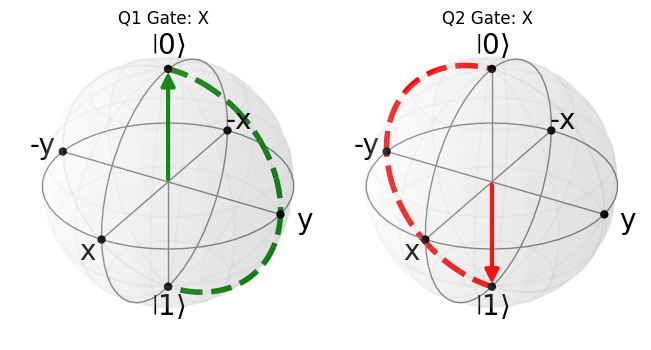

In [ ]:
#scaling to 2Q  #20231011 - method - scalable

wfig = 8.6
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d')
ax1 = fig.add_subplot(spec[0, 1], projection='3d')

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)
b1 = qutip.Bloch(axes=ax1)

#assuming state_arr is obtained from previous config file
#make a list of bloch spheres, list of animation lists and arrays of states per qubit
#we add color vector for distinction
bs_lst_2Q = [b0, b1]
arr_lst_2Q = [state_arr_0, state_arr_1]
arcs_lst_2Q = [state_anim_list_0, state_anim_list_1]
q_cols_2Q = ['g', 'r']
zlabel_2Q = [[r'$\left|0\right>$', r'$\left|1\right>$'],
             [r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_2Q = [[ax0, gate_names_0], [ax1, gate_names_1]]

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  gate_labels are list of [axes, gate_labels] according to the 1Q list
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  ax_dumb = []
  for m in range(len(bs_lst)):
    #m = 1 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
    # annotate gate on title. one can do arrays of labels.
    ax = gate_labels[m][0]
    ax.set_title('Q' + str(int(m+1)) + ' Gate: ' + gate_labels[m][1][j])
    ax_dumb.append(ax)
  # return gate_labels[:][0] has a problematic output not expected
  return ax_dumb

def init(bs_lst, qcols, gate_labels):
    ax_dumb = []
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
      #https://stackoverflow.com/questions/75492605/animate-labels-using-funcanimation-in-matplotlib
      ax = gate_labels[m][0] #retrieve selected axes depending on number of bloch sphere
      ax_dumb.append(ax)
    return ax_dumb

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_2Q,
 arr_lst=arr_lst_2Q,
 arcs_lst=arcs_lst_2Q,
 qcols=q_cols_2Q,
                                           zlabels=zlabel_2Q,
                                           gate_labels=glabel_2Q),
                              np.arange(len(arr_lst_2Q[0])),
                              init_func = partial(init, bs_lst_2Q, q_cols_2Q,
                                                  glabel_2Q),
                              repeat=False)
fname = 'b_sphere_'+'2Q_'+purpose_0+'_q2c'+'.mp4' #with trajectory
ani.save(fname, fps=5)

#Runtime = 32s

Perform state animation of Q1 qubit but with synchronized plot of x-vs-yplot.

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

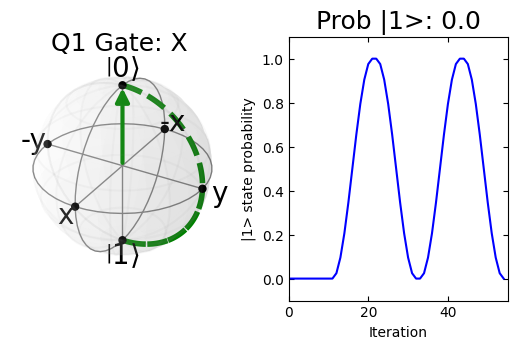

In [ ]:
#scaling to 1Q with xy plot  #20230928 - method

wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize = (1.5*cm_to_inch(8.6),
                                                    1*cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d') #bloch sphere q0
ax1 = fig.add_subplot(spec[0, 1]) #probability of oscillation

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)

# assuming state_arr is obtained from previous config file
# make a list of bloch spheres, list of animation lists and arrays of states per
# qubit
# we add color vector for distinction
bs_lst_1Q_plot = [b0]
arr_lst_1Q_plot = [state_arr_0]
arcs_lst_1Q_plot = [state_anim_list_0]
q_cols_1Q_plot= ['g']
zlabel_1Q_plot = [[r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_1Q_plot = [gate_names_0] #simpler but requires non-automated axes

# set plot for initial qubit probability for 4 X gates
iter = np.linspace(0, len(state_arr_0) - 1, len(state_arr_0))
#scat = ax1.scatter(0, prob_1_state_arr_0[0], c="b", s=5) #plot scatter data
line = ax1.plot(0, prob_1_state_arr_0[0], 'b-')[0] #plot line data
ax1.set(xlim=[0, len(iter)], ylim=[-0.1, 1.1], xlabel='Iteration', ylabel='|1> state probability')
ax1.tick_params(direction='in', right=True, top=True)

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  for m in range(len(bs_lst)):
    #m = 2 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
  ax0.set_title('Q1 Gate: ' + gate_labels[0][j], fontsize=18)

  #set axes plot for |1> probability x vs y axis
  #example - https://matplotlib.org/stable/users/explain/animations/animations.html
  # had to insert label here
  ax1.set_title('Prob |1>: ' + str(round(prob_1_state_arr_0[i], 3)), fontsize=18)
  # for each frame, update the data stored on each artist.
  x = iter[:int(i+1)]
  y = prob_1_state_arr_0[:int(i+1)]
  # update the scatter plot:
  data = np.stack([x, y]).T
  #put argument to plot scatter plot or line
  plot = 'line'
  if plot != 'line':
    #give scatter plot
    scat.set_offsets(data) #scatter plot
  else:
    # update the line plot
    line.set_xdata(x)
    line.set_ydata(y)
  return ax0, ax1

def init(bs_lst, qcols, gate_labels):
    # b-sphare
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
    return ax0, ax1

# inquiry with the working of the code
# does the init() function acts as precursor. Also, how do we scale the bloch
# sphere to 5Q and 9Q in sequence
# init bloch sphere states must be embedded in place.

#for scalabe lsts of states, update bs_list according to the list of operations
#and use partial
#https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_1Q_plot,
 arr_lst=arr_lst_1Q_plot,
 arcs_lst=arcs_lst_1Q_plot,
 qcols=q_cols_1Q_plot,
                                           zlabels=zlabel_1Q_plot,
                                           gate_labels=glabel_1Q_plot),
                              np.arange(len(state_arr_0)),
                              init_func = partial(init, bs_lst_1Q_plot, q_cols_1Q_plot,
                                                  glabel_1Q_plot),
                              repeat=False)
fname = 'b_sphere_'+'1Q_' + purpose_0 + '_' + test_q0 + '_plot.mp4' #with trajectory
ani.save(fname, fps=5) #after 20231019

#time = 38s

Perform state animation of Q0 and Q1_x qubits with synchronized plot of x-vs-yplot. (one possibility)

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

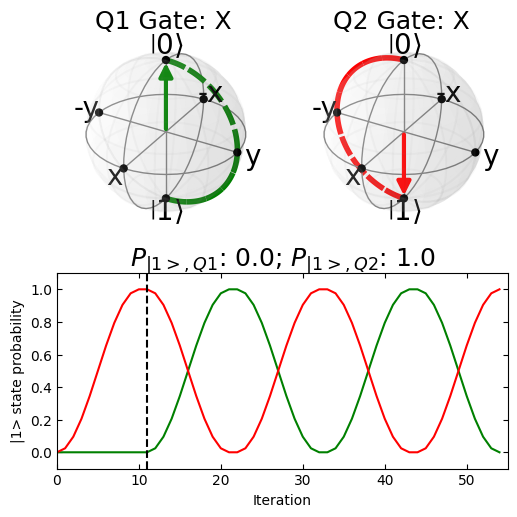

In [ ]:
#scaling to 1Q with xy plot  #20230928 - method

wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize = (1.5*cm_to_inch(8.6),
                                                    1.5*cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d') #bloch sphere q0
ax1 = fig.add_subplot(spec[0, 1], projection='3d') #bloch sphere q1
ax2 = fig.add_subplot(spec[1, :]) #probability of oscillation

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)
b1 = qutip.Bloch(axes=ax1)

# assuming state_arr is obtained from previous config file
# make a list of bloch spheres, list of animation lists and arrays of states per
# qubit
# we add color vector for distinction
bs_lst_2Q_plot = [b0, b1]
arr_lst_2Q_plot = [state_arr_0, state_arr_1]
arcs_lst_2Q_plot = [state_anim_list_0, state_anim_list_1]
q_cols_2Q_plot= ['g', 'r']
zlabel_2Q_plot = [[r'$\left|0\right>$', r'$\left|1\right>$'],
                  [r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_2Q_plot = [gate_names_0, gate_names_1] #simpler but requires non-automated axes

# set plot for Q0 qubit probability
iter = np.linspace(0, len(state_arr_0) - 1, len(state_arr_0))
#scat_0 = ax2.scatter(0, prob_1_state_arr_0[0], c=q_cols_2Q_plot[0], s=5) #plot scatter data
line_0 = ax2.plot(0, prob_1_state_arr_0[0], c=q_cols_2Q_plot[0])[0] #plot line data
#scat_1 = ax2.scatter(0, prob_1_state_arr_0[1], c=q_cols_2Q_plot[1], s=5) #plot scatter data
line_1 = ax2.plot(0, prob_1_state_arr_0[1], c=q_cols_2Q_plot[1])[0] #plot line data

#format ax2 for the plot
ax2.set(xlim=[0, len(iter)], ylim=[-0.1, 1.1], xlabel='Iteration', ylabel=r'|1> state probability')
ax2.tick_params(direction='in', right=True, top=True)
ax2.vlines(x = [11], ymin = -0.1, ymax = 1.1, ls='dashed', color='k')
#add vline dashed for measurement

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
      # in the future, for joint states, one can write dates.
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  for m in range(len(bs_lst)):
    #m = 2 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
  ax0.set_title('Q1 Gate: ' + gate_labels[0][j], fontsize=18)
  ax1.set_title('Q2 Gate: ' + gate_labels[1][j], fontsize=18)

  #set axes plot for |1> probability x vs y axis
  #example - https://matplotlib.org/stable/users/explain/animations/animations.html
  # had to insert label here

  ax2.set_title(r'$P_{|1>,Q1}$: ' + str(round(prob_1_state_arr_0[i], 3)) +
                r'; $P_{|1>,Q2}$: ' + str(round(prob_1_state_arr_1[i], 3)),
                fontsize=18)
  # for each frame, update the data stored on each artist.
  x = iter[:int(i+1)]
  y_0 = prob_1_state_arr_0[:int(i+1)]
  y_1 = prob_1_state_arr_1[:int(i+1)]
  # update the scatter plot:
  data_0 = np.stack([x, y_0]).T
  data_1 = np.stack([x, y_1]).T
  #put argument to plot scatter plot or line
  plot = 'line'
  if plot != 'line':
    #give scatter plot
    scat_0.set_offsets(data_0) #scatter plot
    scat_1.set_offsets(data_1) #scatter plot
  else:
    # update the line plot Q0
    line_0.set_xdata(x)
    line_0.set_ydata(y_0)
    # update the line plot Q1
    line_1.set_xdata(x)
    line_1.set_ydata(y_1)
  return ax0, ax1, ax2

def init(bs_lst, qcols, gate_labels):
    # b-sphare
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
    return ax0, ax1, ax2

# inquiry with the working of the code
# does the init() function acts as precursor. Also, how do we scale the bloch
# sphere to 5Q and 9Q in sequence
# init bloch sphere states must be embedded in place.

#for scalabe lsts of states, update bs_list according to the list of operations
#and use partial
#https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

ani = animation.FuncAnimation(fig, partial(animate_add_vec,
                                           bs_lst=bs_lst_2Q_plot,
 arr_lst=arr_lst_2Q_plot,
 arcs_lst=arcs_lst_2Q_plot,
 qcols=q_cols_2Q_plot,
                                           zlabels=zlabel_2Q_plot,
                                           gate_labels=glabel_2Q_plot),
                              np.arange(len(state_arr_0)),
                              init_func = partial(init, bs_lst_2Q_plot,
                                                  q_cols_2Q_plot,
                                                  glabel_2Q_plot),
                              repeat=False)
fname = 'b_sphere_'+'2Q_' + purpose_0 + '_q2c' +'_plot.mp4' #with trajectory
ani.save(fname, fps=5)

#runtime = 59s

Perform state animation of Q0_x Q0_y; Q1 qubits with synchronized plot of x-vs-yplot. (two possibility) - 20231019

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

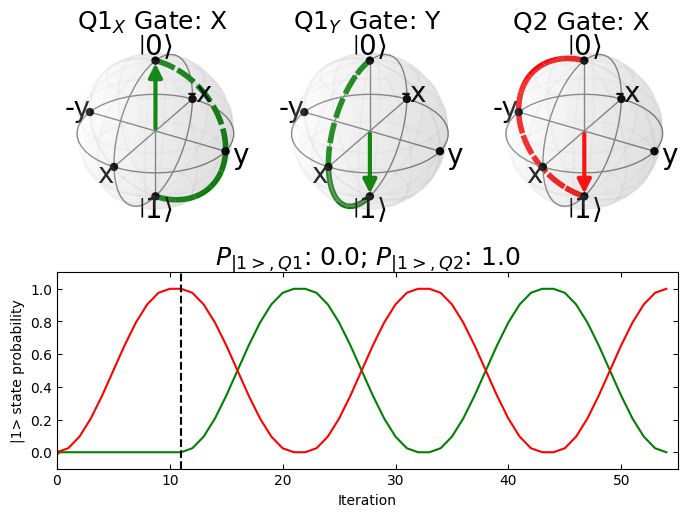

In [ ]:
#scaling to 2Q with xy plot  #20231023 - method

wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize = (2.0*cm_to_inch(8.6),
                                                    1.5*cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d') #bloch sphere q0_x
ax0y = fig.add_subplot(spec[0, 1], projection='3d') #bloch sphere q0_y
ax1 = fig.add_subplot(spec[0, 2], projection='3d') #bloch sphere q1
ax2 = fig.add_subplot(spec[1, :]) #probability of oscillation

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0) #Qubit rotation outcome at X-axis
b0y = qutip.Bloch(axes=ax0y) #Qubit rotation outcome at Y-axis
b1 = qutip.Bloch(axes=ax1) #Qubit control rotation at X-axis

# assuming state_arr is obtained from previous config file
# make a list of bloch spheres, list of animation lists and arrays of states per
# qubit
# we add color vector for distinction
bs_lst_2Q_plot = [b0, b0y, b1]
arr_lst_2Q_plot = [state_arr_0, state_arr_0y, state_arr_1]
arcs_lst_2Q_plot = [state_anim_list_0, state_anim_list_0y, state_anim_list_1]
q_cols_2Q_plot= ['g', 'g', 'r']
zlabel_2Q_plot = [[r'$\left|0\right>$', r'$\left|1\right>$'],
                  [r'$\left|0\right>$', r'$\left|1\right>$'],
                  [r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_2Q_plot = [gate_names_0, gate_names_0y,
                  gate_names_1] #simpler but requires non-automated axes

# set plot for Q0 qubit probability
iter = np.linspace(0, len(state_arr_0) - 1, len(state_arr_0))
scat_0 = ax2.scatter(0, prob_1_state_arr_0[0], c=q_cols_2Q_plot[0], s=5) #plot scatter data
line_0 = ax2.plot(0, prob_1_state_arr_0[0], c=q_cols_2Q_plot[0])[0] #plot line data
scat_1 = ax2.scatter(0, prob_1_state_arr_0[2], c=q_cols_2Q_plot[2], s=5) #plot scatter data
line_1 = ax2.plot(0, prob_1_state_arr_0[2], c=q_cols_2Q_plot[2])[0] #plot line data

#format ax2 for the plot
ax2.set(xlim=[0, len(iter)], ylim=[-0.1, 1.1], xlabel='Iteration', ylabel=r'|1> state probability')
ax2.tick_params(direction='in', right=True, top=True)
ax2.vlines(x = [11], ymin = -0.1, ymax = 1.1, ls='dashed', color='k')
#add vline dashed for measurement

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
      # in the future, for joint states, one can write dates.
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel=zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  for m in range(len(bs_lst)):
    #m = 2 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
  ax0.set_title(r'Q1$_{X}$ Gate: ' + gate_labels[0][j], fontsize=18)
  ax0y.set_title(r'Q1$_{Y}$ Gate: ' + gate_labels[1][j], fontsize=18)
  ax1.set_title(r'Q2 Gate: ' + gate_labels[2][j], fontsize=18)

  #set axes plot for |1> probability x vs y axis
  #example - https://matplotlib.org/stable/users/explain/animations/animations.html
  # had to insert label here

  ax2.set_title(r'$P_{|1>,Q1}$: ' + str(round(prob_1_state_arr_0[i], 3)) +
                r'; $P_{|1>,Q2}$: ' + str(round(prob_1_state_arr_1[i], 3)),
                fontsize=18)
  # for each frame, update the data stored on each artist.
  x = iter[:int(i+1)]
  y_0 = prob_1_state_arr_0[:int(i+1)]
  y_1 = prob_1_state_arr_1[:int(i+1)]
  # update the scatter plot:
  data_0 = np.stack([x, y_0]).T
  data_1 = np.stack([x, y_1]).T
  #put argument to plot scatter plot or line
  plot = 'line'
  if plot != 'line':
    #give scatter plot
    scat_0.set_offsets(data_0) #scatter plot
    scat_1.set_offsets(data_1) #scatter plot
  else:
    # update the line plot Q0
    line_0.set_xdata(x)
    line_0.set_ydata(y_0)
    # update the line plot Q1
    line_1.set_xdata(x)
    line_1.set_ydata(y_1)
  return ax0, ax0y, ax1, ax2

def init(bs_lst, qcols, gate_labels):
    # b-sphare
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
    return ax0, ax0y, ax1, ax2

# inquiry with the working of the code
# does the init() function acts as precursor. Also, how do we scale the bloch
# sphere to 5Q and 9Q in sequence
# init bloch sphere states must be embedded in place.

#for scalabe lsts of states, update bs_list according to the list of operations
#and use partial
#https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

ani = animation.FuncAnimation(fig, partial(animate_add_vec,
                                           bs_lst=bs_lst_2Q_plot,
 arr_lst=arr_lst_2Q_plot,
 arcs_lst=arcs_lst_2Q_plot,
 qcols=q_cols_2Q_plot,
                                           zlabels=zlabel_2Q_plot,
                                           gate_labels=glabel_2Q_plot),
                              np.arange(len(state_arr_0)),
                              init_func = partial(init, bs_lst_2Q_plot,
                                                  q_cols_2Q_plot,
                                                  glabel_2Q_plot),
                              repeat=False)

func = 'xy'
fname = 'b_sphere_'+'2Q_' + purpose_0 + '_q2c' + func + '_plot.mp4' #with trajectory
ani.save(fname, fps=5)

#runtime = 1m 14s

## 2) CZ Gate

In [ ]:
#test init states
dict_psi = {'test_0': basis(2,0),
            'test_1': basis(2,1),
            'test_+': (1/np.sqrt(2))*(basis(2,0) + basis(2,1)),
            'test_-': (1/np.sqrt(2))*(basis(2,0) - basis(2,1)),
            'test_+j': (1/np.sqrt(2))*(basis(2,0) + 1j*basis(2,1)),
            'test_-j': (1/np.sqrt(2))*(basis(2,0) - 1j*basis(2,1))}

Animate CZ operation with Targer Q2 in |0> and |1> state.

In [ ]:
# configuration file includes gate sequences
test_q1_0 = 'test_0' #Q1 control
test_q1_1 = 'test_0' #Q1 control
test_q2_0 = 'test_0' #Q2 target
test_q2_1 = 'test_0' #Q2 target
pts = 11

psi_testq1_0 = dict_psi[test_q1_0] #target
psi_testq1_1 = dict_psi[test_q1_1] #target
psi_testq2_0 = dict_psi[test_q2_0] #control
psi_testq2_1 = dict_psi[test_q2_1] #control

#gate series for CNOT test Q1
purpose = 'CZ'
purpose_1 = purpose + '_q1c' #c means control
gate_list_q1_0 = ['I', 'I', 'I'] # suggested by CCD control
gate_angle_q1_0 = np.asarray([0 for i in range(len(gate_list_q1_0))])
gate_list_q1_1 = ['Y', 'I', 'I'] # after 20231019 - qutech
gate_list_q1_1 = ['X', 'I', 'I'] # after 20231019
gate_angle_q1_1 = gate_angle_q1_0

purpose_2 = purpose + '_q2t' #t means target
gate_list_q2_0 = ['I', 'RY', 'I'] # 3 gates - qutech
gate_list_q2_0 = ['I', 'RX', 'I'] # 3 gates
gate_angle_q2_0 = np.asarray([0, 90, 0])
gate_list_q2_1 = ['I', 'RY', 'Z'] # 3 gates, pi phase shift rotation = qutech
gate_list_q2_1 = ['I', 'RX', 'Z'] # 3 gates, pi phase shift rotation - AS
gate_angle_q2_1 = np.asarray([0, 90, 180])

#Make I gate
def user_gate_I():
     # Identity Gate
     mat = np.array([[1.,   0],
                     [0., 1.]])
     return Qobj(mat, dims=[[2], [2]])

#Control Qubit Scenario

#Plot circuits and get list of states of qubit 1_{x} Q1
qc_q1_0 = QubitCircuit(N=1)
qc_q1_0.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_q1_0.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?
n = len(gate_list_q1_0) #assuming len(gate_list_0) = len(gate_list_1)

[qc_q1_0.add_gate(gate_list_q1_0[i], targets=0) if gate_list_q1_0[i][0] != 'R'
else qc_q1_0.add_gate(gate_list_q1_0[i], targets=0,
                 arg_value=np.radians(gate_angle_q1_0[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_q1_0[i])) for i in range(n)]

# plot circuits of Q0 (Named Q1)
qc_q1_0.draw(file_type='png', file_name='circuit_Q1_0_' + purpose_1)

#Plot circuits and get list of states of qubit 0=|1>
qc_q1_1 = QubitCircuit(N=1)
qc_q1_1.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_q1_1.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

#make an argument to
[qc_q1_1.add_gate(gate_list_q1_1[i], targets=0) if gate_list_q1_1[i][0] != 'R'
else qc_q1_1.add_gate(gate_list_q1_1[i], targets=0,
                 arg_value=np.radians(gate_angle_q1_1[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_q1_1[i])) for i in range(n)]
# plot circuits of Q1 (named Q1)
qc_q1_1.draw(file_type='png', file_name='circuit_Q1_1_' + purpose_1)


#Target Qubit
#Plot circuits and get list of states of qubit 2 = |0>
qc_q2_0 = QubitCircuit(N=1)
qc_q2_0.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_q2_0.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?

#make an argument to
[qc_q2_0.add_gate(gate_list_q2_0[i], targets=0) if gate_list_q2_0[i][0] != 'R'
else qc_q2_0.add_gate(gate_list_q2_0[i], targets=0,
                 arg_value=np.radians(gate_angle_q2_0[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_q2_0[i])) for i in range(n)]
# plot circuits of Q2
qc_q2_0.draw(file_type='png', file_name='circuit_Q2_0' + purpose_2)

#Plot circuits and get list of states of qubit 2 = |1>
qc_q2_1 = QubitCircuit(N=1)
qc_q2_1.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_q2_1.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?

#make an argument to
[qc_q2_1.add_gate(gate_list_q2_1[i], targets=0) if gate_list_q2_1[i][0] != 'R'
else qc_q2_1.add_gate(gate_list_q2_1[i], targets=0,
                 arg_value=np.radians(gate_angle_q2_1[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_q2_1[i])) for i in range(n)]
# plot circuits of Q2
qc_q2_0.draw(file_type='png', file_name='circuit_Q2_1' + purpose_2)

#relabel gates for tracking in animation
gate_names_q1_0 = [gate_list_q1_0[i] if (gate_list_q1_0[i][0] != 'R')
                else (gate_list_q1_0[i] + '(' + str(gate_angle_q1_0[i])
                + r'$^{o}$' + ')') for i in range(n)]

gate_names_q1_1 = [gate_list_q1_1[i] if (gate_list_q1_1[i][0] != 'R')
                else (gate_list_q1_1[i] + '(' + str(gate_angle_q1_1[i]) + r'$^{o}$' + ')')
                for i in range(n)]

gate_names_q2_0 = [gate_list_q2_0[i] if (gate_list_q2_0[i][0] != 'R')
                else (gate_list_q2_0[i] + '(' + str(gate_angle_q2_0[i]) + r'$^{o}$' + ')')
                for i in range(n)]

gate_names_q2_1 = [gate_list_q2_1[i] if (gate_list_q2_1[i][0] != 'R')
                else (gate_list_q2_1[i] + '(' + str(gate_angle_q2_1[i]) + r'$^{o}$' + ')')
                for i in range(n)]

#use propagators - propagators work only for 1Q
props_q1_0 = qc_q1_0.propagators()
#print(props_q1_0)

#For potential 1y as suggested by CCD.
props_q1_1 = qc_q1_1.propagators()
#print(props_q1_1)

props_q2_0 = qc_q2_0.propagators()
#print(props_q2_0)

props_q2_1 = qc_q2_1.propagators()
#print(props__q2_1)


# Advantages: no need for making a unitary matrix
#set final and initial state of access
gate_fin_arr_q1_0 = [psi_testq1_0 for i in range(n)]
gate_fin_arr_q1_1 = [psi_testq1_1 for i in range(n)]
gate_fin_arr_q2_0 = [psi_testq2_0 for i in range(n)]
gate_fin_arr_q2_1 = [psi_testq2_1 for i in range(n)]

for i in range(n):
   if i == 0:
     gate_fin_arr_q1_0[i] = Qobj(props_q1_0[i]*gate_fin_arr_q1_0[i])
     gate_fin_arr_q1_1[i] = Qobj(props_q1_1[i]*gate_fin_arr_q1_1[i])
     gate_fin_arr_q2_0[i] = Qobj(props_q2_0[i]*gate_fin_arr_q2_0[i])
     gate_fin_arr_q2_1[i] = Qobj(props_q2_1[i]*gate_fin_arr_q2_1[i])
   else:
     gate_fin_arr_q1_0[i] = Qobj(props_q1_0[i]*gate_fin_arr_q1_0[i-1])
     gate_fin_arr_q1_1[i] = Qobj(props_q1_1[i]*gate_fin_arr_q1_1[i-1])
     gate_fin_arr_q2_0[i] = Qobj(props_q2_0[i]*gate_fin_arr_q2_0[i-1])
     gate_fin_arr_q2_1[i] = Qobj(props_q2_1[i]*gate_fin_arr_q2_1[i-1])

  #this can be made in list-comprehension for speed.
  #advantage

gate_start_arr_q1_0 = [psi_testq1_0] + gate_fin_arr_q1_0[:int(n-1)]
gate_start_arr_q1_1 = [psi_testq1_1] + gate_fin_arr_q1_1[:int(n-1)]
gate_start_arr_q2_0 = [psi_testq2_0] + gate_fin_arr_q2_0[:int(n-1)]
gate_start_arr_q2_1 = [psi_testq2_1] + gate_fin_arr_q2_1[:int(n-1)]

# for debug purposes
debug = 'N'
if debug == 'Y':
  #Get Initial State
  print('State after Operation Q1_0:')
  print( gate_fin_arr_q1_0)
  print('\n')
  print('State after Operation Q1_1:')
  print(gate_fin_arr_q1_1)
  print('\n')
  print('State after Operation Q2_0:')
  print(gate_fin_arr_q2_0)
  print('\n')
  print('State after Operation Q2_1:')
  print(gate_fin_arr_q2_1)
  print('\n')

  #get initial state before gate operation for iterative generation of animation
  print('State before Operation Q1_0:')
  print(gate_start_arr_q1_0)
  print('State before Operation Q1_1:')
  print(gate_start_arr_q1_1)
  print('State before Operation Q2_0:')
  print(gate_start_arr_q2_0)
  print('State before Operation Q2_1:')
  print(gate_start_arr_q2_1)

/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


In [ ]:
#make sequential animation to highlight trajectories
#Q1_0
state_anim_list_q1_0 = [rot_R(init_list=[gate_start_arr_q1_0[i], 0, gate_list_q1_0[i]],
                         angle=gate_angle_q1_0[i], pts=pts)[1] for i in range(n)]
#Q1_1
state_anim_list_q1_1 = [rot_R(init_list=[gate_start_arr_q1_1[i], 0, gate_list_q1_1[i]],
                            angle=gate_angle_q1_1[i], pts=pts)[1] for i in range(n)]
#Q2_0
state_anim_list_q2_0 = [rot_R(init_list=[gate_start_arr_q2_0[i], 0, gate_list_q2_0[i]],
                         angle=gate_angle_q2_0[i], pts=pts)[1] for i in range(n)]

#Q2_1
state_anim_list_q2_1 = [rot_R(init_list=[gate_start_arr_q2_1[i], 0, gate_list_q2_1[i]],
                         angle=gate_angle_q2_1[i], pts=pts)[1] for i in range(n)]

print('\n')
print('Number of Q1_0 gates: {:1d}'.format(len(state_anim_list_q1_0)))
print('Number of animation per Q0 gate : {:1d}'.format(len(state_anim_list_q1_0[0])))
print('\n')
print('Number of Q1_1 gates: {:1d}'.format(len(state_anim_list_q1_1)))
print('Number of animation per Q1_1 gate : {:1d}'.format(len(state_anim_list_q1_1[0])))
print('\n')
print('Number of Q2_0 gates: {:1d}'.format(len(state_anim_list_q2_0)))
print('Number of animation per Q2 gate : {:1d}'.format(len(state_anim_list_q2_0[0])))
print('\n')
print('Number of Q2_1 gates: {:1d}'.format(len(state_anim_list_q2_1)))
print('Number of animation per Q2 gate : {:1d}'.format(len(state_anim_list_q2_1[0])))

def flatten_comprehension(matrix):
  #Try flatten gates for drawing arcs per gate
  #https://realpython.com/python-flatten-list/
  return [item for row in matrix for item in row]

state_arr_q1_0 = flatten_comprehension(state_anim_list_q1_0)
state_arr_q1_1 = flatten_comprehension(state_anim_list_q1_1)
state_arr_q2_0 = flatten_comprehension(state_anim_list_q2_0)
state_arr_q2_1 = flatten_comprehension(state_anim_list_q2_1)
print('\n')
print('Number of animation per Q1_0 list: {:1d}'.format(len(state_arr_q1_0)))
print('Number of animation per Q1_1 list: {:1d}'.format(len(state_arr_q1_1)))
print('Number of animation per Q2_0 list: {:1d}'.format(len(state_arr_q2_0)))
print('Number of animation per Q2_1 list: {:1d}'.format(len(state_arr_q2_1)))



Number of Q1_0 gates: 3
Number of animation per Q0 gate : 11


Number of Q1_1 gates: 3
Number of animation per Q1_1 gate : 11


Number of Q2_0 gates: 3
Number of animation per Q2 gate : 11


Number of Q2_1 gates: 3
Number of animation per Q2 gate : 11


Number of animation per Q1_0 list: 33
Number of animation per Q1_1 list: 33
Number of animation per Q2_0 list: 33
Number of animation per Q2_1 list: 33


### Case where control Q1 = |0> and Q2 =|0> having no rotation

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

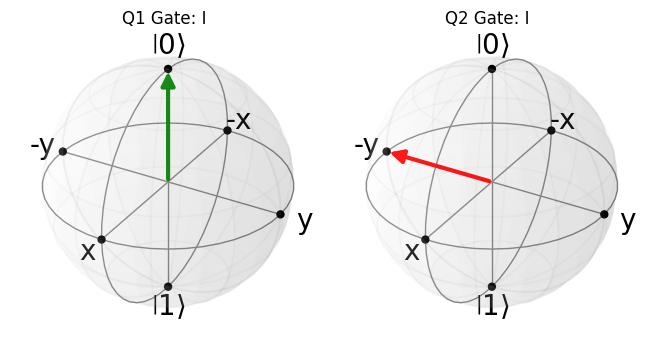

In [ ]:
#scaling to 2Q  #20231011 - method - scalable

wfig = 8.6
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d')
ax1 = fig.add_subplot(spec[0, 1], projection='3d')

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)
b1 = qutip.Bloch(axes=ax1)

#assuming state_arr is obtained from previous config file
#make a list of bloch spheres, list of animation lists and arrays of states per qubit
#we add color vector for distinction
bs_lst_2Q = [b0, b1]
arr_lst_2Q = [state_arr_q1_0, state_arr_q2_0]
arcs_lst_2Q = [state_anim_list_q1_0, state_anim_list_q2_0]
q_cols_2Q = ['g', 'r']
zlabel_2Q = [[r'$\left|0\right>$', r'$\left|1\right>$'],
             [r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_2Q = [[ax0, gate_names_q1_0], [ax1, gate_names_q2_0]]

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
      # in the future, for joint states, one can write dates.
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  gate_labels are list of [axes, gate_labels] according to the 1Q list
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  ax_dumb = []
  for m in range(len(bs_lst)):
    #m = 1 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
    # annotate gate on title. one can do arrays of labels.
    ax = gate_labels[m][0]
    ax.set_title('Q' + str(int(m+1)) + ' Gate: ' + gate_labels[m][1][j])
    ax_dumb.append(ax)
  # return gate_labels[:][0] has a problematic output not expected
  return ax_dumb

def init(bs_lst, qcols, gate_labels):
    ax_dumb = []
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
      #https://stackoverflow.com/questions/75492605/animate-labels-using-funcanimation-in-matplotlib
      ax = gate_labels[m][0] #retrieve selected axes depending on number of bloch sphere
      ax_dumb.append(ax)
    return ax_dumb

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_2Q,
 arr_lst=arr_lst_2Q,
 arcs_lst=arcs_lst_2Q,
 qcols=q_cols_2Q,
                                           zlabels=zlabel_2Q,
                                           gate_labels=glabel_2Q),
                              np.arange(len(arr_lst_2Q[0])),
                              init_func = partial(init, bs_lst_2Q, q_cols_2Q,
                                                  glabel_2Q),
                              repeat=False)
func_0 = '=|0>'
func_n = '_CCD'
fname = 'b_sphere_'+'2Q_'+purpose_1+func_0+'_q2t'+func_n+'.mp4' #with trajectory
#ani.save(fname, fps=10) #before suggestion by CCD
ani.save(fname, fps=5)

#time = 21s
#this library rpoves that as long as the output of animate and init are the same,
#it can put the plots well enough for analysis

### Case where Control Q1 = |1> and Q2 = |0> having Z full rotation. (Reference: Two qubit gates qutech: https://www.youtube.com/watch?v=vwjlEdwi2LU)

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

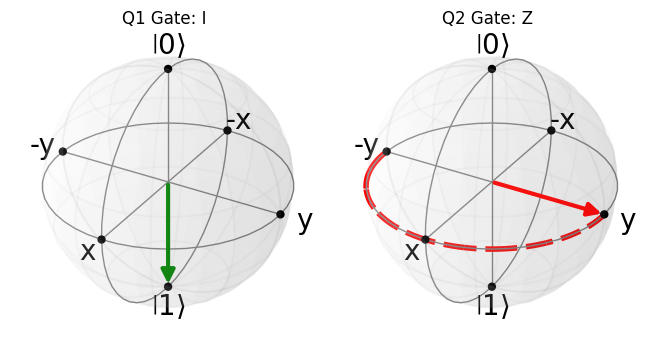

In [ ]:
#scaling to 2Q  #20231011 - method - scalable

wfig = 8.6
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d')
ax1 = fig.add_subplot(spec[0, 1], projection='3d')

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)
b1 = qutip.Bloch(axes=ax1)

#assuming state_arr is obtained from previous config file
#make a list of bloch spheres, list of animation lists and arrays of states per qubit
#we add color vector for distinction
bs_lst_2Q = [b0, b1]
arr_lst_2Q = [state_arr_q1_1, state_arr_q2_1]
arcs_lst_2Q = [state_anim_list_q1_1, state_anim_list_q2_1]
q_cols_2Q = ['g', 'r']
zlabel_2Q = [[r'$\left|0\right>$', r'$\left|1\right>$'],
             [r'$\left|0\right>$', r'$\left|1\right>$']]
glabel_2Q = [[ax0, gate_names_q1_1], [ax1, gate_names_q2_1]]

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  gate_labels are list of [axes, gate_labels] according to the 1Q list
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  ax_dumb = []
  for m in range(len(bs_lst)):
    #m = 1 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
    # annotate gate on title. one can do arrays of labels.
    ax = gate_labels[m][0]
    ax.set_title('Q' + str(int(m+1)) + ' Gate: ' + gate_labels[m][1][j])
    ax_dumb.append(ax)
  return ax_dumb

def init(bs_lst, qcols, gate_labels):
    ax_dumb = []
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
      #https://stackoverflow.com/questions/75492605/animate-labels-using-funcanimation-in-matplotlib
      ax = gate_labels[m][0] #retrieve selected axes depending on number of bloch sphere
      ax_dumb.append(ax)
    return ax_dumb

ani = animation.FuncAnimation(fig, partial(animate_add_vec, bs_lst=bs_lst_2Q,
 arr_lst=arr_lst_2Q,
 arcs_lst=arcs_lst_2Q,
 qcols=q_cols_2Q,
                                           zlabels=zlabel_2Q,
                                           gate_labels=glabel_2Q),
                              np.arange(len(arr_lst_2Q[0])),
                              init_func = partial(init, bs_lst_2Q, q_cols_2Q,
                                                  glabel_2Q),
                              repeat=False)
func_1 = '=|1>'
func_n = '_CCD'
fname = 'b_sphere_'+'2Q_'+purpose_1+func_1+'_q2t'+func_n+'.mp4' #with trajectory
ani.save(fname, fps=5)

#time = 21s

### |11> => |02> swap (RY rotations)
We perform SWAP action between two computational states for a qubit and plot the swapping action of |11> and |02> - coherent exchange (based on interaction with Prof. CCD for the interaction point).

References:
1. Kwon, S., Tomonaga, A., Lakshmi Bhai, G., Devitt, S. J., & Tsai, J.-S. (2021). Gate-based superconducting quantum computing. Journal of Applied Physics, 129(4), 041102. doi:10.1063/5.0029735

In [ ]:
# configuration file includes gate sequences
test_q0 = 'test_1' #Q1 target |having 0 and 1 basis>
test_q1 = 'test_0' #Q2 control |having |1> (former: |0>) and |2>(former: |1>) basis>
pts = 11
psi_test0 = dict_psi[test_q0] #target
psi_test1 = dict_psi[test_q1] #control

#gate series for ISWAP test Q1
purpose = 'CZ-swap'
purpose_0 = purpose + '_q1c' #t means target
gate_list_0 = ['Y', 'Y', 'Y', 'Y', 'Y'] # Starting on |1> state going to |0> state
#I is an unknown gate in qutip-qip
gate_angle_0 = np.asarray([180 for i in range(len(gate_list_0))])

#Y-possibility
gate_list_0y = ['Y', 'Y', 'Y', 'Y', 'Y'] # after 20231019
gate_angle_0y = gate_angle_0

# after CCD assessment, gate series for ISWAP test Q2
# Y-possibility
purpose_1 = purpose + '_q2t' #c means control
gate_list_1 = ['Y', 'Y', 'Y', 'Y', 'Y'] # after 20231019
gate_angle_1 = gate_angle_0
#print(gate_list_1)
#print(gate_angle_1)

#Make I gate
def user_gate_I():
     # Identity Gate
     mat = np.array([[1.,   0],
                     [0., 1.]])
     return Qobj(mat, dims=[[2], [2]])

#Plot circuits and get list of states of qubit 1_{x} Q1
qc_0 = QubitCircuit(N=1)
qc_0.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_0.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?
n = len(gate_list_0) #assuming len(gate_list_0) = len(gate_list_1)

# we remove a classical register for simplicity
# 20231018 - Add I gate for confirmation.
# https://qutip.org/docs/latest/guide/qip/qip-basics.html

[qc_0.add_gate(gate_list_0[i], targets=0) if gate_list_0[i][0] != 'R'
else qc_0.add_gate(gate_list_0[i], targets=0,
                 arg_value=np.radians(gate_angle_0[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_0[i])) for i in range(n)]

# plot circuits of Q0 (Named Q1)
qc_0.draw(file_type='png', file_name='circuit_Q1_' + purpose_0)

#Plot circuits and get list of states of qubit 2
qc_1 = QubitCircuit(N=1)
qc_1.user_gates = {"I": user_gate_I} #add I-gate

# add control line that applies the gates
qc_1.add_state(state='0', targets=[0], state_type='input') #qubit operated upon Q0

# Automate gate list. Is it necessary to put classical controls?

#make an argument to
[qc_1.add_gate(gate_list_1[i], targets=0) if gate_list_1[i][0] != 'R'
else qc_1.add_gate(gate_list_1[i], targets=0,
                 arg_value=np.radians(gate_angle_1[i]),
                 arg_label=r'{:1d}^o'.format(gate_angle_1[i])) for i in range(n)]
# plot circuits of Q2
qc_1.draw(file_type='png', file_name='circuit_Q2_' + purpose_1)

#relabel gates for tracking in animation
gate_names_0 = [gate_list_0[i] if (gate_list_0[i][0] != 'R')
                else (gate_list_0[i] + '(' + str(gate_angle_0[i]) + r'$^{o}$' + ')')
                for i in range(n)]

gate_names_1 = [gate_list_1[i] if (gate_list_1[i][0] != 'R')
                else (gate_list_1[i] + '(' + str(gate_angle_1[i]) + r'$^{o}$' + ')')
                for i in range(n)]

#use propagators - propagators work only for 1Q
props_0 = qc_0.propagators()
print(props_0)

props_1 = qc_1.propagators()
#print(props_1)

# Advantages: no need for making a unitary matrix
#set final and initial state of access
gate_fin_arr_0 = [psi_test0 for i in range(n)]
gate_fin_arr_1 = [psi_test1 for i in range(n)]

for i in range(n):
   if i == 0:
     gate_fin_arr_0[i] = Qobj(props_0[i]*gate_fin_arr_0[i])
     gate_fin_arr_1[i] = Qobj(props_1[i]*gate_fin_arr_1[i])

   else:
     gate_fin_arr_0[i] = Qobj(props_0[i]*gate_fin_arr_0[i-1])
     gate_fin_arr_1[i] = Qobj(props_1[i]*gate_fin_arr_1[i-1])

  #this can be made in list-comprehension for speed.
  #advantage

gate_start_arr_0 = [psi_test0] + gate_fin_arr_0[:int(n-1)]
gate_start_arr_1 = [psi_test1] + gate_fin_arr_1[:int(n-1)]

# for debug purposes
debug = 'N'
if debug == 'Y':
  #Get Initial State
  print('State after Operation Q0:')
  print(gate_fin_arr_0)
  print('\n')
  print('State after Operation Q1:')
  print(gate_fin_arr_1)
  print('\n')

  #get initial state before gate operation for iterative generation of animation
  print('State before Operation Q0:')
  print(gate_start_arr_0)
  print('State before Operation Q1:')
  print(gate_start_arr_1)

/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]]


/usr/local/lib/python3.10/dist-packages/qutip_qip/circuit/circuit_latex.py:95: UserWarning: Could not locate system 'pdfcrop': image output may have additional margins.
  warnings.warn(


In [ ]:
#make sequential animation to highlight trajectories
#Q1
state_anim_list_0 = [rot_R(init_list=[gate_start_arr_0[i], 0, gate_list_0[i]],
                         angle=gate_angle_0[i], pts=pts)[1] for i in range(n)]
#Q2 - modification [|0> -> |1> state, |1> -> |2> state]
state_anim_list_1 = [rot_R(init_list=[gate_start_arr_1[i], 0, gate_list_1[i]],
                         angle=gate_angle_1[i], pts=pts)[1] for i in range(n)]

print('\n')
print('Number of Q0 gates: {:1d}'.format(len(state_anim_list_0)))
print('Number of animation per Q0 gate : {:1d}'.format(len(state_anim_list_0[0])))
print('\n')
print('\n')
print('Number of Q1 gates: {:1d}'.format(len(state_anim_list_1)))
print('Number of animation per Q1 gate : {:1d}'.format(len(state_anim_list_1[0])))

def flatten_comprehension(matrix):
  #Try flatten gates for drawing arcs per gate
  #https://realpython.com/python-flatten-list/
  return [item for row in matrix for item in row]

state_arr_0 = flatten_comprehension(state_anim_list_0)
state_arr_1 = flatten_comprehension(state_anim_list_1)
print('\n')
print('Number of animation per Q0 list: {:1d}'.format(len(state_arr_0)))
print('Number of animation per Q1 list: {:1d}'.format(len(state_arr_1)))

##Create data for those things.
#practice getting probability of |1> state

#get two-qubit probabilities
#Q1
prob_1_state_arr_0 = np.array([extract_state_info_qt(state_arr_0[i])['prob'][1] for i in range(len(state_arr_0))]) #Q1 |measure 1>
#Q2 - modification [|0> -> |1> state, |1> -> |2> state] -> changing frame to |1> as ground state
prob_1_state_arr_1 = np.array([extract_state_info_qt(state_arr_1[i])['prob'][0] for i in range(len(state_arr_1))])
#take |1> state occupation
print('Q0 |1> probability={:.3f}'.format(prob_1_state_arr_0[2]))
print('Q1 |1> probability={:.3f}'.format(prob_1_state_arr_1[2]))
print('\n')
#get |11> probabilites
prob_11_state_arr = np.array([prob_1_state_arr_0[i]*prob_1_state_arr_1[i] for i in range(len(state_arr_1))])
#prob_11_state_arr



Number of Q0 gates: 5
Number of animation per Q0 gate : 11




Number of Q1 gates: 5
Number of animation per Q1 gate : 11


Number of animation per Q0 list: 55
Number of animation per Q1 list: 55
Q0 |1> probability=0.905
Q1 |1> probability=0.905




0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

0


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

1


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

2


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

3


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

4


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

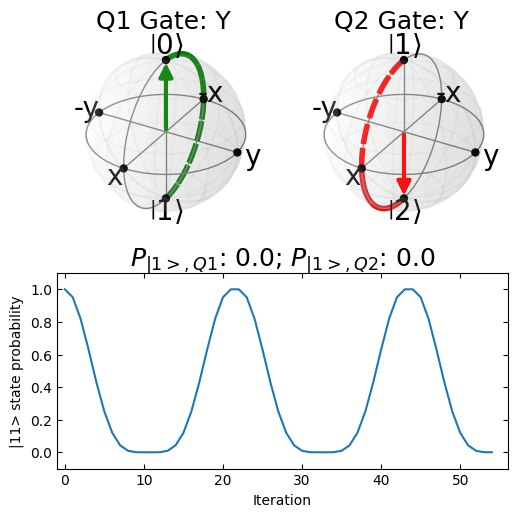

In [ ]:
#scaling to 1Q with xy plot  #20230928 - method

wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize = (1.5*cm_to_inch(8.6),
                                                    1.5*cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0], projection='3d') #bloch sphere q0
ax1 = fig.add_subplot(spec[0, 1], projection='3d') #bloch sphere q1
ax2 = fig.add_subplot(spec[1, :]) #probability of oscillation

#set initial config to bloch spheres with corresponding axes labels
#i.e. b0 = qutip.Bloch(axes=ax0), b1=qutip.Bloch(axes=ax1) ...
b0 = qutip.Bloch(axes=ax0)
b1 = qutip.Bloch(axes=ax1)

# assuming state_arr is obtained from previous config file
# make a list of bloch spheres, list of animation lists and arrays of states per
# qubit
# we add color vector for distinction
bs_lst_2Q_plot = [b0, b1]
arr_lst_2Q_plot = [state_arr_0, state_arr_1]
arcs_lst_2Q_plot = [state_anim_list_0, state_anim_list_1]
q_cols_2Q_plot= ['g', 'r']
zlabel_2Q_plot = [[r'$\left|0\right>$', r'$\left|1\right>$'],
                  [r'$\left|1\right>$', r'$\left|2\right>$']]
glabel_2Q_plot = [gate_names_0, gate_names_1] #simpler but requires non-automated axes

# set plot for Q0 qubit probability
iter = np.linspace(0, len(state_arr_0) - 1, len(state_arr_0))
# - color is blue for the 2Q state
#scat_0 = ax2.scatter(0, prob_11_state_arr[0], c='tab:blue', s=5) #plot scatter data
line_0 = ax2.plot(0, prob_11_state_arr[0], c='tab:blue')[0] #plot line data

#format ax2 for the plot
ax2.set(xlim=[-1, len(iter)+1], ylim=[-0.1, 1.1], xlabel='Iteration',
        ylabel=r'|11> state probability')
ax2.tick_params(direction='in', right=True, top=True)
#ax2.vlines(x = [11], ymin = -0.1, ymax = 1.1, ls='dashed', color='k')
#add vline dashed for measurement

def initiate_bloch_qn_with_arc(bs, list_states=[], qcol='g', zlabel=[]):
    """
    Initialize plot of bloch sphere. Must be dedicated to only one sphere of
    interest. The good thing is that one can externally assign bloch spheres
    for modification.

    In the future, it would be nice to extend labeling Z-axes for information.

    Based on old script

    Parameters
    ----------
    bs : Bloch
      qutip bloch sphere
    list_states: list of Qobj
      state vectors giving hints for arc trajectory
    *kwargs: additional keynote arguments


    Returns
    -------
    None.

    """
    # Highlight nodes on diagram
    # |0>, -y, +x, +y
    # D:\Postgrad Projects\Qiskit_Textbook\bloch sphere plotting\qutip q2_sq cz_operate\Qutip q1=0.py
    xp = np.asarray([0, 0, 1, 0, 0, -1])
    yp = np.asarray([0, -1, 0, 1, 0, 0])
    zp = np.asarray([1, 0, 0, 0, -1, 0])
    pnts = [xp, yp, zp]
    bs.add_points(pnts)
    #check for same states for arc

    #draw arc based on states
    if list_states == []:
      #no need for drawing arcs if no arcs are intended to be drawn
      pass
    else:
      list_coords = gate_arcs_all(list_states) #shows 3 points
      f = len(list_states)
      m = int((f-1)/2) #mid point
      if ((round(list_coords[0][0],6) == round(list_coords[-1][0],6))
      & (round(list_coords[0][1],6) == round(list_coords[-1][1],6))
      & (round(list_coords[0][-1],6) == round(list_coords[-1][-1],6))):
        # make a pass if a coordinate arr[0][x,y,z] and arr[-1][x,y,z] of an arc has the same point
        # round is added to remove rounding errors
        pass
      else:
        #draw all arcs #Optimal Hadamard Trajectories are hard from transpiler
        [bs.add_arc(start=list_coords[i], end=list_coords[i+1], fmt=qcol,
                          ls='dashed', lw=4) for i in range(f-1)]

    # Format Bloch Sphere first
    bs.vector_color = [qcol, qcol, qcol, qcol]
    bs.frame_alpha = 0.05
    bs.point_color = ['k', 'k', 'k', 'k', '#CC6600']
    bs.point_marker = ['o', 'o', 'o', 'o']
    bs.frame_num = 12
    bs.sphere_alpha = 0.1
    bs.xlabel = ['x', '-x']
    bs.ylabel = ['y', '-y']
    bs.sphere_color = 'white'
    if zlabel == []:
      bs.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
      # in the future, for joint states, one can write dates.
    else:
      bs.zlabel = zlabel

def b_plot(i, j, bs, b_states, b_state_arcs, qcol, zlabel):
  """
  methood to scale up bs config.
  scale b sphere according to number of bloch spheres
  i - frames in int
  j - number of batches of frames in int
  b_sphere - bloch number
  b_states - list of states evolved by i
  b_state_arcs - list of state_arcs evolved by j
  qcol - color of vectors
  zlabel - assignment of states
  """
  bs.clear()
  initiate_bloch_qn_with_arc(bs, b_state_arcs[j], qcol, zlabel)
  bs.add_states([b_states[i]])
  bs.show()

def animate_add_vec(i, bs_lst, arr_lst, arcs_lst, qcols, zlabels, gate_labels):
  """
  animate bloch sphere entertaining configs of bloch plots.
  for every bloch sphere, there returns a corresponding axes
  i = frames
  bs_list is the bloch spheres of concern
  arr_lst is a list of 1D states all qubit vector works,
  arcs_lst is a list of arcs used for qubit gates
  qcols are list of colors of each qubit states
  z-labels are lists of states needed for operation. Default is [[], []]
  """
  #assign j for number of points per movie

  pts = len(arcs_lst[0][0]) #pts per gate
  j = int(i/(pts))
  j_max = int(len(arr_lst[0])/pts)
  print(j)
  for m in range(len(bs_lst)):
    #m = 2 for this list
    b_plot(i, j, bs_lst[m], arr_lst[m], arcs_lst[m], qcols[m], zlabels[m])
  ax0.set_title('Q1 Gate: ' + gate_labels[0][j], fontsize=18)
  ax1.set_title('Q2 Gate: ' + gate_labels[1][j], fontsize=18)

  #set axes plot for |1> probability x vs y axis
  #example - https://matplotlib.org/stable/users/explain/animations/animations.html
  # had to insert label here

  ax2.set_title(r'$P_{|1>,Q1}$: ' + str(round(prob_1_state_arr_0[i], 3)) +
                r'; $P_{|1>,Q2}$: ' + str(round(prob_1_state_arr_1[i], 3)),
                fontsize=18)
  # for each frame, update the data stored on each artist.
  x = iter[:int(i+1)]
  y_11 = prob_11_state_arr[:int(i+1)]
  # update the scatter plot:
  data_11 = np.stack([x, y_11]).T
  #put argument to plot scatter plot or line
  plot = 'line'
  if plot != 'line':
    #give scatter plot
    scat_0.set_offsets(data_11) #scatter plot
  else:
    # update the line plot 2Q|11>
    line_0.set_xdata(x)
    line_0.set_ydata(y_11)
  return ax0, ax1, ax2

def init(bs_lst, qcols, gate_labels):
    # b-sphare
    for m in range(len(bs_lst)):
      bs_lst[m].vector_color = [qcols[m]]
    return ax0, ax1, ax2

# inquiry with the working of the code
# does the init() function acts as precursor. Also, how do we scale the bloch
# sphere to 5Q and 9Q in sequence
# init bloch sphere states must be embedded in place.

#for scalabe lsts of states, update bs_list according to the list of operations
#and use partial
#https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

ani = animation.FuncAnimation(fig, partial(animate_add_vec,
                                           bs_lst=bs_lst_2Q_plot,
 arr_lst=arr_lst_2Q_plot,
 arcs_lst=arcs_lst_2Q_plot,
 qcols=q_cols_2Q_plot,
                                           zlabels=zlabel_2Q_plot,
                                           gate_labels=glabel_2Q_plot),
                              np.arange(len(state_arr_0)),
                              init_func = partial(init, bs_lst_2Q_plot,
                                                  q_cols_2Q_plot,
                                                  glabel_2Q_plot),
                              repeat=False)
fname = 'b_sphere_'+'2Q_' + purpose_1 + '_q1c' +'_plot.mp4' #with trajectory
ani.save(fname, fps=5)

#time = 1m 5s

Note that the animation is an approximate as we have not established any 2-Qubit bloch sphere yet. Bloch sphere is only limited to two states and dealing with more than 3 states is something a bloch sphere is not capable of dealing. Further research is needed to fully visualize 2Q states and G states. The sequences capture the periodicity but not the |11>-|02> oscillations, which is purely sinusoidal.

In [ ]:
from qutip.ipynbtools import version_table
version_table() #this is good

Software,Version
QuTiP,4.7.3
Numpy,1.23.5
SciPy,1.11.3
matplotlib,3.7.1
Cython,3.0.3
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.34.0
Python,"3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]"
OS,posix [linux]


References:

[1] Casparis, L., Larsen, T. W., Olsen, M. S., Kuemmeth, F., Krogstrup, P., Nygard, J., . . . Marcus, C. M. (2016). Gatemon Benchmarking and Two-Qubit Operations. Phys Rev Lett, 116(15), 150505. doi:10.1103/PhysRevLett.116.150505

[2] Tholen, M. O., Borgani, R., Di Carlo, G. R., Bengtsson, A., Krizan, C., Kudra, M., . . . Haviland, D. B. (2022). Measurement and control of a superconducting quantum processor with a fully integrated radio-frequency system on a chip. Rev Sci Instrum, 93(10), 104711. doi:10.1063/5.0101398  